# Working with imbalanced data

In machine learning it is quite usual to have to deal with imbalanced dataset. This is particularly true in online learning for tasks such as fraud detection and spam classification. In these two cases, which are binary classification problems, there are usually many more 0s than 1s, which generally hinders the performance of the classifiers we thrown at them.

As an example we'll use the credit card dataset available in `creme`. We'll first use a `collections.Counter` to count the number of 0s and 1s in order to get an idea of the class balance.

In [1]:
import collections
from creme import datasets

X_y = datasets.CreditCard()

counts = collections.Counter(y for _, y in X_y)

for c, count in counts.items():
    print(f'{c}: {count} ({count / sum(counts.values()):.5%})')

0: 284315 (99.82725%)
1: 492 (0.17275%)


The dataset is quite unbalanced. For each 1 there are about 578 0s. Let's now train a logistic regression with default parameters and see how well it does. We'll measure the ROC AUC score.

In [2]:
from creme import linear_model
from creme import metrics
from creme import model_selection
from creme import preprocessing


X_y = datasets.CreditCard()

model = (
    preprocessing.StandardScaler() |
    linear_model.LogisticRegression()
)

metric = metrics.ROCAUC()

model_selection.progressive_val_score(
    X_y,
    model,
    metric,
    print_every=15_000
)

[15,000] ROCAUC: 0.899341
[30,000] ROCAUC: 0.87079
[45,000] ROCAUC: 0.899804
[60,000] ROCAUC: 0.89192
[75,000] ROCAUC: 0.890126
[90,000] ROCAUC: 0.897645
[105,000] ROCAUC: 0.889682
[120,000] ROCAUC: 0.886271
[135,000] ROCAUC: 0.883233
[150,000] ROCAUC: 0.885329
[165,000] ROCAUC: 0.897751
[180,000] ROCAUC: 0.896706
[195,000] ROCAUC: 0.896068
[210,000] ROCAUC: 0.894425
[225,000] ROCAUC: 0.893745
[240,000] ROCAUC: 0.893375
[255,000] ROCAUC: 0.89189
[270,000] ROCAUC: 0.893778


ROCAUC: 0.891071

The performance is already quite acceptable, but as we will now see we can do even better. The first thing we can do is to add weight to the 1s by using the `class_weight` argument of the `LogisticRegression` class. Under the hood this will increase the magnitude of the gradient. Intuitively this helps the model on rare examples.

In [3]:
from creme import datasets
from creme import linear_model
from creme import metrics
from creme import model_selection
from creme import preprocessing


X_y = datasets.CreditCard()

model = (
    preprocessing.StandardScaler() |
    linear_model.LogisticRegression(
        class_weights={0: 1, 1: 4}
    )
)

metric = metrics.ROCAUC()

model_selection.progressive_val_score(
    X_y,
    model,
    metric,
    print_every=15_000
)

[15,000] ROCAUC: 0.907733
[30,000] ROCAUC: 0.913497
[45,000] ROCAUC: 0.935347
[60,000] ROCAUC: 0.92263
[75,000] ROCAUC: 0.917461
[90,000] ROCAUC: 0.923706
[105,000] ROCAUC: 0.913346
[120,000] ROCAUC: 0.910504
[135,000] ROCAUC: 0.909895
[150,000] ROCAUC: 0.909142
[165,000] ROCAUC: 0.918603
[180,000] ROCAUC: 0.918592
[195,000] ROCAUC: 0.916969
[210,000] ROCAUC: 0.915904
[225,000] ROCAUC: 0.915336
[240,000] ROCAUC: 0.915016
[255,000] ROCAUC: 0.914223
[270,000] ROCAUC: 0.915509


ROCAUC: 0.912311

Adding importance weights only works with gradient-based models (which includes neural networks). A more generic, and potentially more effective approach, is to use undersamplig and oversampling. As an example, we'll under-sample the stream so that our logistic regression encounter 20% of 1s and 80% of 0s. Under-sampling has the additional benefit of requiring less training steps, and thus reduces the total training time.

In [4]:
from creme import imblearn


X_y = datasets.CreditCard()

model = (
    preprocessing.StandardScaler() |
    imblearn.RandomUnderSampler(
        classifier=linear_model.LogisticRegression(),
        desired_dist={0: .8, 1: .2},
        seed=42
    )
)

metric = metrics.ROCAUC()

model_selection.progressive_val_score(
    X_y,
    model,
    metric,
    print_every=15_000
)

[15,000] ROCAUC: 0.939633
[30,000] ROCAUC: 0.954278
[45,000] ROCAUC: 0.969119
[60,000] ROCAUC: 0.9602
[75,000] ROCAUC: 0.955892
[90,000] ROCAUC: 0.961742
[105,000] ROCAUC: 0.95182
[120,000] ROCAUC: 0.948409
[135,000] ROCAUC: 0.949267
[150,000] ROCAUC: 0.952339
[165,000] ROCAUC: 0.955113
[180,000] ROCAUC: 0.954583
[195,000] ROCAUC: 0.953861
[210,000] ROCAUC: 0.954009
[225,000] ROCAUC: 0.951322
[240,000] ROCAUC: 0.953741
[255,000] ROCAUC: 0.952319
[270,000] ROCAUC: 0.953518


ROCAUC: 0.950284

The `RandomUnderSampler` is a wrapper for classifiers. This is represented by a rectangle around the logistic regression bubble when we draw the model.

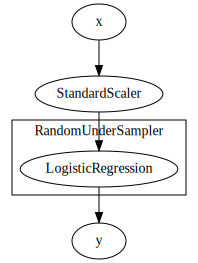

In [12]:
model.draw()